Congratulations! You've been hired as a data scientist at the hottest new social media startup.

Your company produces an app via which users can post short videos for anyone to view. They can also like, repost, and comment on the videos they view. The key data product is a recommendation engine that determines the order in which videos are shown to a user.

The recommendation engine has a parameter, *theta*, that affects the ordering of the videos. Recently the team of engineers that works on the recommendation engine ran it with different settings of *theta* and, for each setting, measured the amount of time users spent on the app. They have collected these measurements into a data set of 20 samples of (*theta*, *time_spent*) pairs.

Additionally, they have identified two auxiliary features (*aux1* and *aux2*) that they hypoithesize should correlate with *time_spent*. These two features are measures of time spent by users in the recent past. The engineers have not verified that the features explain *time_spent*.

(The engineers call these two features "auxiliary" because, while they might help explain *time_spent*, the engineers' ultimate interest lies in the dependence of *time_spent* on *theta*.)

Your first project at your new company is to tell the engineers which setting you think they should use for *theta*, based on the data.

## 1. Prepare the data
- Inspect the data. Identifiy and remove any suspicious or unusable samples.
- Put the samples in a data structure that you can work with.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats
import matplotlib.pyplot as plt

In [ ]:
theta = [0.03906292, 0.05119367, 0.06004468, 0.06790036, 0.19152079,
       0.28298816, 0.294665  , 0.3578136 , 0.48352862, 0.53058676,
       0.55175137, 0.57560289, 0.59751325, 0.6375209 , 0.65241862,
       0.65633352, 0.78698546, 0.8640421 , 0.87729053, 0.94568319]
aux1 = [ 0.53983961, -1.77528229,  1.31487654, -0.47344805, -1.0922299 ,
       -0.25002744, -0.9822943 ,  1.03126909,  0.49133378, -0.4466466 ,
       -0.80636008,  0.13126776, -1.21256024,  0.15999085, -0.75522304,
        0.34989599,  0.97754176, -0.13858525,  0.10385631,  0.30059104]
aux2 = [ 0.9682053 ,  0.86962384,  0.56778309,  0.46528234, -1.16537308,
       -2.03599479, -1.15541329,  3.34515739,  0.12672721, -0.6941789 ,
        0.55767443,  0.0991466 ,  0.63792617,  0.70311068, -0.91609315,
       -0.78601423,  1.1191818 , -0.98339611,  0.24452002, -0.58140974]
time_spent = [10.79768391, 10.87648065, 10.29274937, 10.78756647,  9.51844772,
        9.18078781,  9.90063639, 12.84823357, 10.92743478,  9.88927608,
       11.3373709 , 11.43996915, 11.88392171, -11.88135476, 11.73452467,
       11.18844425, 12.19144316, 11.35294826, 12.2385441 , 11.98428985]

In [ ]:
data = {'theta': theta, 'aux1': aux1, 'aux2': aux2, 'time_spent': time_spent}
df = pd.DataFrame(data)
df.head()

,theta,aux1,aux2,time_spent
0,0.039063,0.539840,0.968205,10.797684
1,0.051194,-1.775282,0.869624,10.876481
2,0.060045,1.314877,0.567783,10.292749
3,0.067900,-0.473448,0.465282,10.787566
4,0.191521,-1.092230,-1.165373,9.518448


In [ ]:
df.describe()

,theta,aux1,aux2,time_spent
count,20.000000,20.000000,20.000000,20.000000
mean,0.475222,-0.126610,0.069323,9.924470
std,0.292726,0.818612,1.168883,5.221924
min,0.039063,-1.775282,-2.035995,-11.881355
25%,0.260121,-0.768007,-0.818534,10.194721
50%,0.541169,-0.017364,0.185624,11.057940
75%,0.653397,0.385255,0.654222,11.771874
max,0.945683,1.314877,3.345157,12.848234


In [ ]:
df.isnull().sum()

theta         0
aux1          0
aux2          0
time_spent    0
dtype: int64

In [ ]:
np.where(df.time_spent<0)

(array([13]),)

In [ ]:
timespent_negative_rows = df.loc[df['time_spent'] < 0].index

print(timespent_negative_rows)

Int64Index([13], dtype='int64')


In [ ]:
#Remove 14th row, maintain the indexing
df.drop(13, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
timespent_negative_rows = df.loc[df['time_spent'] < 0].index

print(timespent_negative_rows)

Int64Index([], dtype='int64')


In [ ]:
df

,theta,aux1,aux2,time_spent
0,0.039063,0.539840,0.968205,10.797684
1,0.051194,-1.775282,0.869624,10.876481
2,0.060045,1.314877,0.567783,10.292749
3,0.067900,-0.473448,0.465282,10.787566
4,0.191521,-1.092230,-1.165373,9.518448
5,0.282988,-0.250027,-2.035995,9.180788
6,0.294665,-0.982294,-1.155413,9.900636
7,0.357814,1.031269,3.345157,12.848234
8,0.483529,0.491334,0.126727,10.927435
9,0.530587,-0.446647,-0.694179,9.889276


In [ ]:
df.describe()

,theta,aux1,aux2,time_spent
count,19.000000,19.000000,19.000000,19.000000
mean,0.466680,-0.141694,0.035966,11.072145
std,0.298175,0.838183,1.191092,0.988303
min,0.039063,-1.775282,-2.035995,9.180788
25%,0.237254,-0.780792,-0.851054,10.540158
50%,0.530587,-0.138585,0.126727,11.188444
75%,0.654376,0.420615,0.602855,11.809223
max,0.945683,1.314877,3.345157,12.848234


## 2. Build a model

Write functions to run a regression, calculate the regression statistics listed below, and print a report.
- B (regressor coefficients plus one for an intercept, if appropriate)
- R2
- RSS
- RegSS
- TSS
- t statistic for each regressor coefficient

I found it useful to decompose the problem into three functions: `regress_calc()`, `regress_tstat()`, and `regress_report()`. You may write it however you see fit.

You may include either, both, or neither of *aux1* and *aux2* in your final model. Experiment. What works best? Justify your decision.

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats

def regress_calc(input_cols):
    X = df[input_cols]
    y = df.iloc[:,-1]
    n = len(X)
    Lin_Reg = LinearRegression().fit(X, y)
    y_hat = Lin_Reg.predict(X)
    y_mean = np.mean(y)
    intercept = Lin_Reg.intercept_
    B = Lin_Reg.coef_
    TSS = sum((y - y_mean)**2)
    RSS = sum((y - y_hat)**2)
    RegSS = TSS - RSS
    R2 = RegSS / TSS
    return intercept, B, R2, RSS, RegSS, TSS

def regress_tstat(input_cols, B):
    X = df[input_cols]
    y = df.iloc[:,-1]
    n = len(X)
    pvalue_sign = []
    alpha = 0.05

    t_scores = B / (np.std(X)/np.sqrt(n))
    p_values = (scipy.stats.t.sf(np.abs(t_scores), df=n))*2
    t_statistics = list(t_scores)

    for i in p_values:
      if i < alpha:
        pvalue_sign.append(True)
      else:
        pvalue_sign.append(False)

    return p_values, pvalue_sign, t_statistics


def regress_report(input_cols):
    intercept, B, R2, RSS, RegSS, TSS = regress_calc(input_cols)
    p_values, pvalue_sign, t_statistics = regress_tstat(input_cols, B)

    print('\nR^2 = {}'.format(R2))
    print('Input columns: {}'.format(input_cols))
    print('Significance of P-Values = {}'.format(pvalue_sign))
    print('Intercept = {}'.format(intercept))
    print('B = {}'.format(B))
    print('RSS = {}'.format(RSS))
    print('RegSS = {}'.format(RegSS))
    print('TSS = {}'.format(TSS))
    print('p_values = {}'.format(p_values))
    print('t_statistic = {}'.format(t_statistics))

In [ ]:
reg_combos = [['theta','aux1','aux2'],['aux1','aux2'],['theta','aux1'],
              ['theta','aux2'],['theta'],['aux1'],['aux2']]

for i in reg_combos:
  regress_report(i)


R^2 = 0.888179612859572
Input columns: ['theta', 'aux1', 'aux2']
Significance of P-Values = [True, False, True]
Intercept = 9.920094669515057
B = [ 2.3876759  -0.10000621  0.65613708]
RSS = 1.9659559596739293
RegSS = 15.615417258118748
TSS = 17.581373217792677
p_values = [6.45018856e-19 5.99313956e-01 2.33039270e-02]
t_statistic = [35.860922062585516, -0.5343249395736329, 2.4669850599262153]

R^2 = 0.41321369485899573
Input columns: ['aux1', 'aux2']
Significance of P-Values = [False, False]
Intercept = 11.070569154567039
B = [0.11530773 0.49808471]
RSS = 10.316509029773574
RegSS = 7.264864188019104
TSS = 17.581373217792677
p_values = [0.5451528  0.07657676]
t_statistic = [0.6160796737330162, 1.8727299331775393]

R^2 = 0.3813885891979512
Input columns: ['theta', 'aux1']
Significance of P-Values = [True, False]
Intercept = 10.283645737202516
B = [1.77398701 0.27796262]
RSS = 10.876038090096085
RegSS = 6.705335127696593
TSS = 17.581373217792677
p_values = [1.64016332e-16 1.53912205e-01]


The R^2 values for all three columns and [theta, aux2] are almost identical at approximately .88. These are the highest values among the combinations of input columns. So, [theta, aux2] works better.

## 3. Propose a setting for *theta*

Now that you have a model built, you should be able to plot estimated *time_spent* vs. *theta* over a reasonable range of *theta*.  By inspecting that plot -- and knowning that the company wants to maximize the time users spend on the app -- which value of *theta* would you propose the engineers use? Explain how the data and your model support your decision.

The engineer's have capacity to take another set of measurements. Which settings of *theta* do you suggest they measure? Why?


In [ ]:
X1 = df[['theta']]
y = df.iloc[:,-1]
reg1 = LinearRegression().fit(X1, y)
y_hat = reg1.predict(X1)

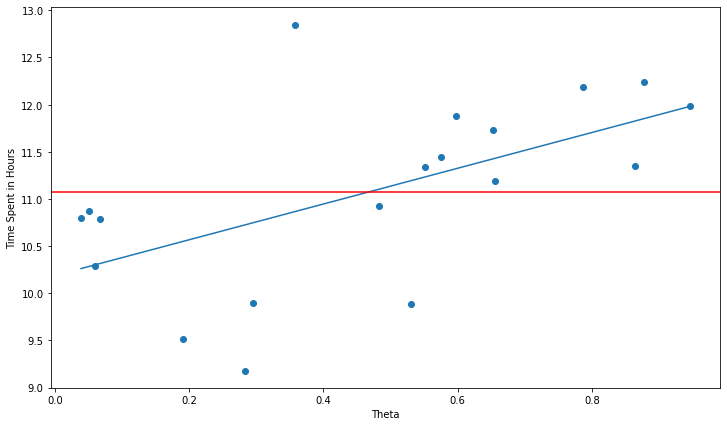

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel('Theta')
plt.ylabel('Time Spent in Hours')
plt.scatter(X1, y)
plt.plot(X1, y_hat)
plt.axhline(df['time_spent'].mean(), color='r')

From the graph we can say there is a postive correrlation between theta and time spent so, there will more time spent hours if the the theta is high. if we take around 0.6 as the minimum thereshold then all points are higher than average time spent.

## 4. Experiment or observation?

Is this data set experimental or observational? Explain clearly. Consider how the effect of *theta* on *time_spent* differs from the effect of *aux1* or *aux2*.

This data set is experimental. Because the engineers manipulated the parameter theta in the recommendation engine to measure the amount of time users spent on the app. By varying the value of theta, they were able to collect data on how the change affected user behavior. This manipulation of the recommendation engine's parameter can be considered an experimental.

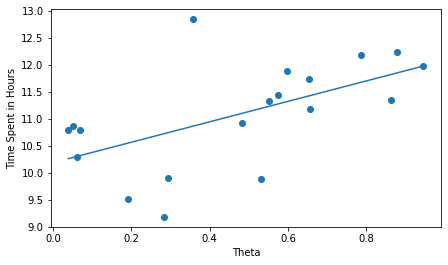

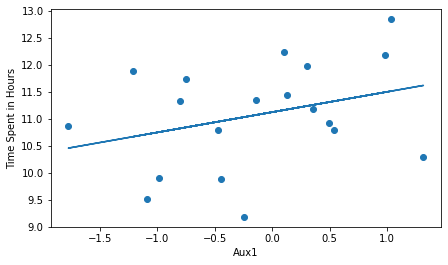

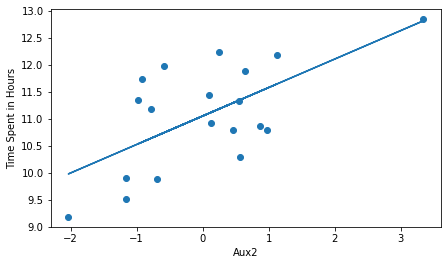

In [ ]:
plt.figure(figsize=(7,4))
plt.xlabel('Theta')
plt.ylabel('Time Spent in Hours')
plt.scatter(X1, y)
plt.plot(X1, y_hat)

X2 = df[['aux1']]
reg2 = LinearRegression().fit(X2, y)
y_hat2 = reg2.predict(X2)
plt.figure(figsize=(7,4))
plt.xlabel('Aux1')
plt.ylabel('Time Spent in Hours')
plt.scatter(X2, y)
plt.plot(X2, y_hat2)

X3 = df[['aux2']]
reg3 = LinearRegression().fit(X3, y)
y_hat3 = reg3.predict(X3)
plt.figure(figsize=(7,4))
plt.xlabel('Aux2')
plt.ylabel('Time Spent in Hours')
plt.scatter(X3, y)
plt.plot(X3, y_hat3)

The statistical analysis indicates that Theta is consistently significant based on the p-values, and there is a positive linear relationship between Theta and the amount of time users spend on the app. By examining the graphs above, it becomes apparent that Theta and Aux2 have a higher positive correlation than Aux1.